### Week 6, Part 2, Exercise 3

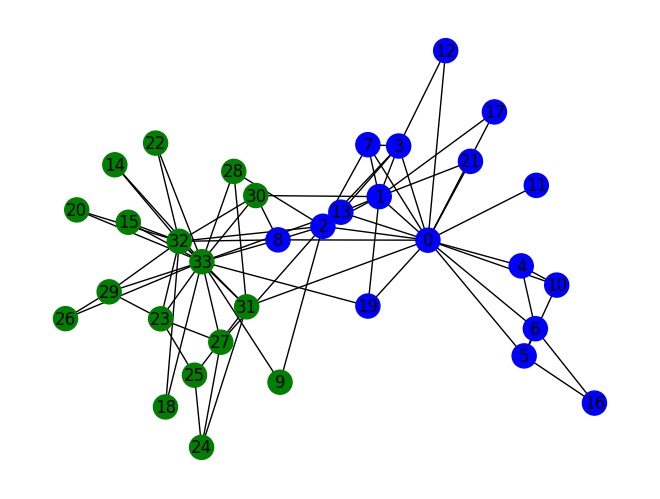

In [58]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.karate_club_graph()

club = nx.get_node_attributes(G, "club")

color_map = []
for node in G.nodes():
    if club[node] == "Mr. Hi":
        color_map.append("blue")
    else:
        color_map.append("green")

MrHiGroup = []
OfficerGroup = []
for i in range(len(color_map)):
    if club[i] == "Mr. Hi":
        MrHiGroup.append(i)
    else:
        OfficerGroup.append(i)

nx.draw(G, with_labels=True, node_color=color_map)
plt.show()


In [59]:
def modularity(G, communities):
    m = G.number_of_edges()
    q = 0.0
    for c in communities:
        lc = G.subgraph(c).number_of_edges()
        kc = sum(G.degree(n) for n in c)
        q += lc/m - (kc/(2*m))**2
    return q

In [61]:
modularity_from_current_communities = modularity(G, [OfficerGroup, MrHiGroup])
modularity_from_current_communities


0.3582347140039447

### What is modularity

Modularity is a number that determines how well some communities (partitions) is distributed in a graph (communities). The higher the modularity, the better the communities have been split up. If the modularity is 0, then there is only 1 community. If modularity is negative, then all nodes are their own community.

### double edge swap algorithm

In [16]:
N = G.number_of_edges()*2

In [17]:
import random

def double_edge_swap_algo(G_original, N):
    G = G_original.copy()
    for i in range(N):
        u, v = random.choice(list(G.edges()))
        x, y = random.choice(list(G.edges()))

        if (u != x) and (v != y) and (not G.has_edge(u, y)) and (not G.has_edge(x, v)):
            # perform the double edge swap
            G.remove_edges_from([(u, v), (x, y)])
            G.add_edges_from([(u, y), (x, v)])
    
    return G


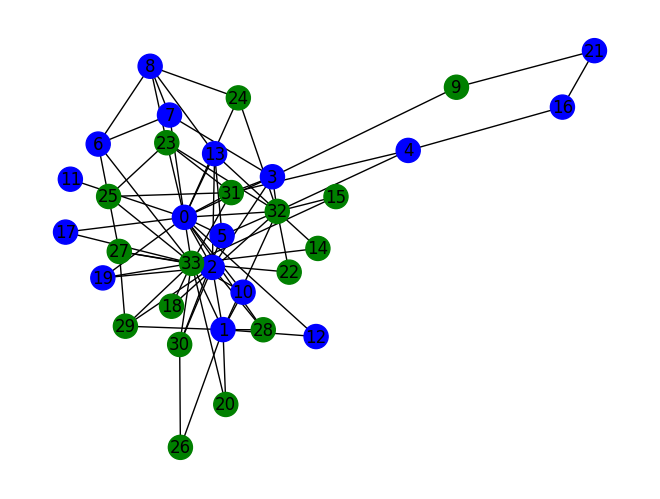

In [19]:
G_double_edge_swap = double_edge_swap_algo(G, N)
nx.draw(G_double_edge_swap, with_labels=True, node_color=color_map)
plt.show()

#### check that function works correct. The two following lists should be the same:

In [22]:
lst_old = [d for n, d in G.degree()]
lst_new = [d for n, d in G_double_edge_swap.degree()]

print("Original degree sequence: ", lst_old)
print("New degree sequence: ", lst_new)
print("Number of errors: ", sum([True for i in range(len(lst_old)) if lst_old[i] != lst_new[i]]))

Original degree sequence:  [16, 9, 10, 6, 3, 4, 4, 4, 5, 2, 3, 1, 2, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 5, 3, 3, 2, 4, 3, 4, 4, 6, 12, 17]
New degree sequence:  [16, 9, 10, 6, 3, 4, 4, 4, 5, 2, 3, 1, 2, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 5, 3, 3, 2, 4, 3, 4, 4, 6, 12, 17]
Number of errors:  0


In [9]:
# new_modularity
modularity(G_double_edge_swap, [OfficerGroup, MrHiGroup])

-0.0007396449704142605

In [55]:
# function to find if modularity is significantly different from 0

import numpy as np

number_of_iterations = 1000
coms = [OfficerGroup, MrHiGroup]

def plot_density(modularities, value):
    plt.hist(modularities, bins=50, alpha=0.5, density=True)
    plt.axvline(x=value, color='r')

    plt.xlabel('Modularity')
    plt.ylabel('Density')
    plt.title('Distribution of Random Modularities with Actual Modularity')
    plt.show()
    

def is_significantly_dif_from_zero(G, value):

    print("current modularity = ", value)

    modularities = []
    for i in range(number_of_iterations):
        current_double_edge_swap = double_edge_swap_algo(G, N)
        current_modularity = modularity(current_double_edge_swap, coms)
        modularities.append(current_modularity)
    
    mean = np.mean(modularities)
    std = np.std(modularities)

    print("mean: ", mean)
    print("std: ", std)

    plot_density(modularities, value)

    if value < mean-2*std or value > mean+2*std:
        print("Value is significantly different")
    else: 
        print("Value is not significantly different")



current modularity =  0.3582347140039447
mean:  -0.0029040358575823763
std:  0.044988571692900964


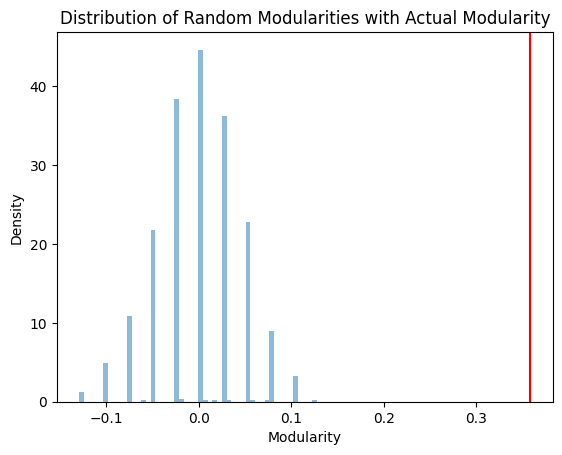

Value is significantly different


In [56]:
is_significantly_dif_from_zero(G, modularity_from_current_communities)

This seems to be a pretty good partitioning. We can clearly see that this partitioning is much better than a random partitioning.

### Louvain Algorithm

In [40]:
import community

partition = community.best_partition(G)
partitions = {}
for i in range(len(partition)):
    group = list(partition.values())[i]
    if group in partitions.keys():
        partitions[group] += [i]
    else:
        partitions[group] = [i]

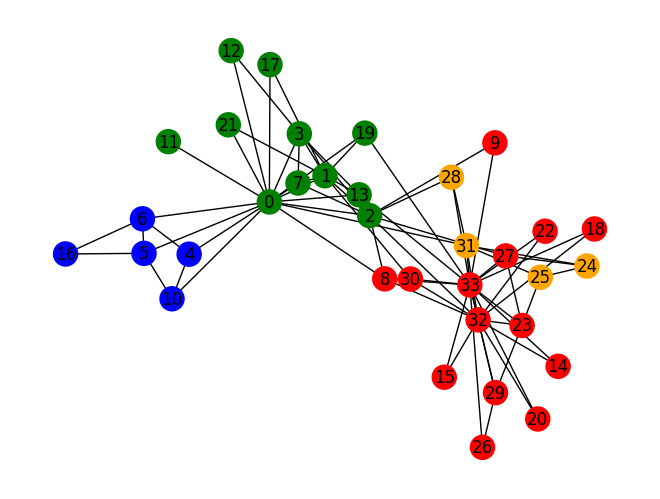

In [49]:
louvain_partitions = list(partitions.values())
louvain_colors = []

for i in range(len(partition)):
    if i in louvain_partitions[0]:
        louvain_colors.append("green")
    if i in louvain_partitions[1]:
        louvain_colors.append("blue")
    if i in louvain_partitions[2]:
        louvain_colors.append("red")
    if i in louvain_partitions[3]:
        louvain_colors.append("orange")

nx.draw(G, with_labels=True, node_color=louvain_colors)
plt.show()


current modularity =  0.4151051939513477
mean:  -0.0024329593150772626
std:  0.0438562065647183


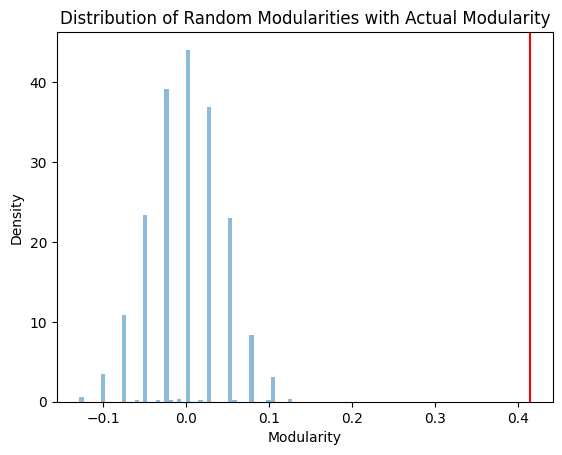

Value is significantly different


In [57]:
louvain_modularity = modularity(G, louvain_partitions)
is_significantly_dif_from_zero(G, louvain_modularity)

### Compare communities:

In [63]:
# number of communities from louvain is 4
D = np.ndarray((2, 4))
D

array([[0., 0., 1., 0.],
       [0., 1., 1., 1.]])

Text(0.5, 1.0, 'Alike in louvain and club group')

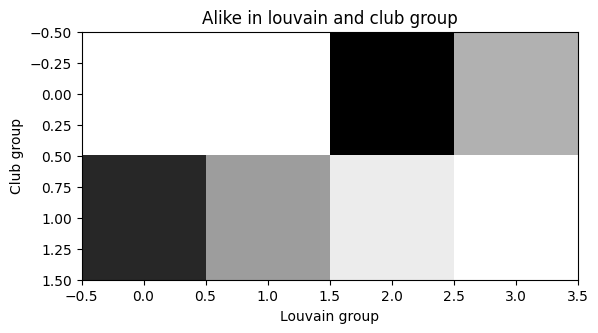

In [66]:
club_split = [OfficerGroup, MrHiGroup]

for i in range(len(club_split)):
    current_club = club_split[i]
    for j in range(len(louvain_partitions)):
        current_partition = louvain_partitions[j]
        alike = sum([True for x in range(len(current_partition)) if current_partition[x] in current_club])
        D[i, j] = alike

plt.imshow(D, cmap='binary')
plt.xlabel("Louvain group")
plt.ylabel("Club group")
plt.title("Alike in louvain and club group")

